# Extreme Value Statistics - An Example (v3)

The example here is from Stuart Cole's book, <i>"An Introduction to Statistical Modeling of Extreme Values"</i>.

<p>The same example is also featured in the R package, <i><b>ismev</b></i>, (see http://cran.r-project.org/web/packages/ismev/).

In [1]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt

import scipy as sp
from scipy.optimize import minimize
from scipy.stats import genextreme

print(f"    Pandas {pd.__version__}")
print(f"     NumPy {np.__version__}")
print(f"MatPlotLib {matplotlib.__version__}")
print(f"     SciPy {sp.__version__}")

    Pandas 1.0.5
     NumPy 1.18.5
MatPlotLib 3.2.2
     SciPy 1.5.0


## DATA: Annual maximum sea-levels at Port Pirie, South Australia

<b>Note on modules used here:</b> Pandas is used to read the CSV file into a Pandas DataFrame, but only for convenience.  Later, when the data analysis starts, the max sea level data will be turned into a standard NumPy ndarray.

In [2]:
#dateparse = lambda x: pd.datetime.strptime(x, '%Y')
dateparse = lambda x: dt.datetime.strptime(x, '%Y')

df = pd.read_csv('datasets/port_pirie.csv', parse_dates=['Year'], date_parser=dateparse)
df.describe()

,SeaLevel
count,65.000000
mean,3.980615
std,0.240513
min,3.570000
25%,3.830000
50%,3.960000
75%,4.110000
max,4.690000


In [3]:
df.head()

,Year,SeaLevel
0,1923-01-01,4.03
1,1924-01-01,3.83
2,1925-01-01,3.65
3,1926-01-01,3.88
4,1927-01-01,4.01


In [4]:
df.tail()

,Year,SeaLevel
60,1983-01-01,4.08
61,1984-01-01,3.90
62,1985-01-01,3.88
63,1986-01-01,3.94
64,1987-01-01,4.33


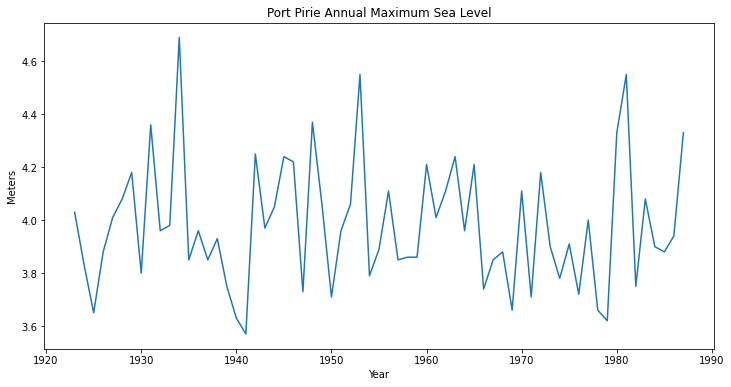

In [5]:
plt.figure(figsize=(12,6))
plt.title('Port Pirie Annual Maximum Sea Level')
plt.xlabel('Year')
plt.ylabel('Meters')
x = [idx.year for idx in df.Year]
y = df.SeaLevel
plt.plot(x,y)

### Histogram of Data

In [6]:
max_sea_levels = df['SeaLevel']

Bin Boundaries: [3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6 4.8]
    Bin Counts: [ 0.  0.  1. 15. 23. 13. 10.  2.  1.]


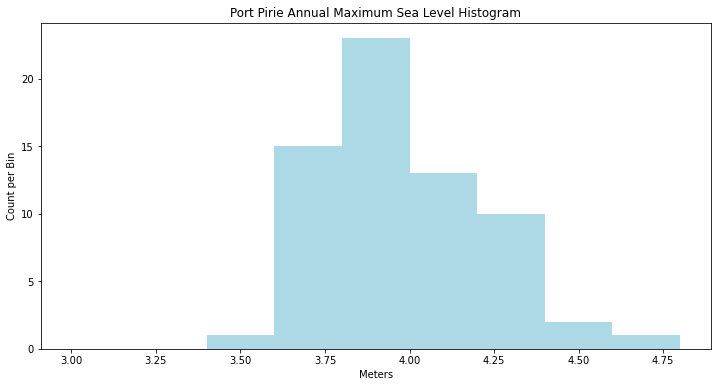

In [7]:
plt.figure(figsize=(12,6))
plt.title("Port Pirie Annual Maximum Sea Level Histogram")
plt.xlabel("Meters")
plt.ylabel("Count per Bin")
result = plt.hist(max_sea_levels, bins=np.arange(3.0, 5.0, 0.2), color='LightBlue')
print("Bin Boundaries: {}".format(result[1]))
print("    Bin Counts: {}".format(result[0]))

## The Generalized Extreme Value (GEV) Distribution

The GEV probability density is given by: $G(z;\mu,\sigma,\xi) = \exp \left( - \left[ 1 + \xi \left( \frac {z - \mu} {\sigma} \right) \right]^{-1/\xi} \right)$ where $-\infty < \mu < \infty$, $\sigma > 0$, $-\infty < \xi < \infty$, and $z$ is such that $1 + \xi(z - \mu)/\sigma > 0$

<b><u>IMPORTANT NOTE</u>:</b> There does not appear to be a standard representation of the GEV distribution.  Algorithms appear to differ on how the <i><b>shape</b></i> parameter, $\xi$, should be represented.  Specifically, the shape parameter in the <i><b>ismev</b></i> package in <b>R</b> is the <u><b>negative</b></u> of the shape parameter in <b><i>scipy.stats.genextreme</i></b>.

<p>This fact will be illustrated in the example below, where two methods for estimating the GEV parameters will be used.</p>

## Estimating the Three GEV Parameters

Below, we'll demonstrate how to estimate the three GEV parameters using two different approaches.  Actually, they're the same approach (Maximum Likelihood Estimation - MLE) but done the <b>Hard Way</b> (by numerical optimization of the log likelihood function) and the <b>Easy Way</b> by just calling the <i><b>fit</b></i> function of the GEV distribution (<i>genextreme</i>) in <i>scipy.stats</i>.

### Method 1: The Hard Way (numerical optimization of the log likelihood function)

Stuart Cole's book is the source for the following log likelihood function.  Note that Cole's book is also the source for the implementation of <i><b>ismev</b></i> in <b>R</b>.

If $Z_1,Z_2,...,Z_m$ are independent random variables with the GEV distribution, then given the observations, $z_i, z_2, ..., z_m$, the parameters, $\mu$, $\sigma$, and $\xi$ can be estimated using the Maximum Likelihood Method.  The log likelihood function, $\ell$, of the parameters is given below.  We need to find the values of $\mu$, $\sigma$, and $\xi$ that maximize $\ell$ for the given sample, $z_i, z_2, ..., z_m$.

$\ell ( \mu, \sigma, \xi )$

$= -m \log(\sigma) - ( 1 + 1 / \xi ) \sum \limits_{i=1}^m \log \left[ 1 + \xi \left( \frac {z_i - \mu} {\sigma} \right) \right] - \sum\limits_{i=1}^m \left[ 1 + \xi \left( \frac {z_i - \mu} {\sigma} \right) \right]^{-1/\xi}$

where $\xi \ne 0$ and $1 + \xi \left( \frac {z_i - \mu} {\sigma} \right) > 0$ for $i=1,...,m$

The function below implements the log likelihood function, above, and uses a standard optimization algorithm, <i>scipy.optimize.minimize</i>, to find the MLE for the EVT parameters.  Basically, it maximizes the GEV log likelihood function by minimizing its negative.

In [8]:
def gev_max_likelihood_estimate(data, starting_shape_estimate=0.1, minimization_method='nelder-mead',
                                tolerance=1e-8, display=True):
    '''Returns the maximum likelihood estimate of the three parameters of the Generalized Extreme
    Value (GEV) distribution: mu (location), sigma (scale), and xi (shape).'''
    def log_likelihood(w): # 'w' is assumed to be a tuple: (mu, sigma, xi)
        sum1 = 0.0; sum2 = 0.0
        mu = w[0]; sigma = w[1]; xi = w[2]
        for z in data:
            x = 1 + xi * ((z-mu)/sigma)
            sum1 += np.log(x)
            sum2 += x**(-1.0/xi)
        return -((-len(data) * np.log(sigma)) - (1 + 1/xi)*sum1 - sum2) # negated so we can use 'minimum'
    starting_parameter_estimate = (data.mean(), data.std(), starting_shape_estimate)
    return minimize(log_likelihood, starting_parameter_estimate, method=minimization_method,
                    options={'xtol': tolerance, 'disp': display})

#### Now calculate the MLE for the sea level data

In [9]:
mle = gev_max_likelihood_estimate(max_sea_levels)

Optimization terminated successfully.
         Current function value: -4.339058
         Iterations: 148
         Function evaluations: 277


In [10]:
mle

 final_simplex: (array([[ 3.87474985,  0.19804396, -0.05010952],
       [ 3.87474986,  0.19804396, -0.05010952],
       [ 3.87474986,  0.19804396, -0.05010953],
       [ 3.87474986,  0.19804396, -0.05010952]]), array([-4.33905847, -4.33905847, -4.33905847, -4.33905847]))
           fun: -4.3390584736794295
       message: 'Optimization terminated successfully.'
          nfev: 277
           nit: 148
        status: 0
       success: True
             x: array([ 3.87474985,  0.19804396, -0.05010952])

#### The three parameter estimates are contained in the array, x, returned by the MLE estimation

In [11]:
mle.x

array([ 3.87474985,  0.19804396, -0.05010952])

In [12]:
mu = mle.x[0]
sigma = mle.x[1]
xi = mle.x[2]
print("The mean, sigma, and shape parameters are {}, {}, and {}, resp.".format(mu, sigma, xi))

The mean, sigma, and shape parameters are 3.8747498544435586, 0.19804395918541323, and -0.05010952175148731, resp.


### Method 2: The Easy Way - Use scipy.stats.genextreme.fit

The "fit" command estimates the MLE parameters of whatever continuous distribution you are working with in scipy.stats -- in this case, the GEV (genextreme).

In [13]:
mle2 = genextreme.fit(max_sea_levels)
mle2

(0.05010534785328627, 3.874758730628963, 0.19803814023673208)

<b>Note that the shape parameter, above, is 0.0501..., whereas the shape parameter that was derived earlier was the negative of this (-0.0501...).</b>

In [14]:
mu = mle2[1]
sigma = mle2[2]
xi = mle2[0]
print("The mean, sigma, and shape parameters are {}, {}, and {}, resp.".format(mu, sigma, xi))

The mean, sigma, and shape parameters are 3.874758730628963, 0.19803814023673208, and 0.05010534785328627, resp.


### Plot of the estimated Probabililty Density Function (PDF) along with a normalized histogram of the data

This density (actually, its cumulative distribution function (CDF) and the CDF inverse) can be used to calculate probabilities of greater values.  But the PDF is handy to look at and compare to a normalized plot of the data.

The GEV PDF is a library function in <i>scipy.stats</i> called, <i>genextreme</i>.  All we have to do is fill in the three GEV parameters that were estimated, above, to get the PDF for our sample data.

In [15]:
def sea_levels_gev_pdf(x):
    return genextreme.pdf(x, xi, loc=mu, scale=sigma)

In [16]:
x = np.linspace(3.0, 6.0, num=100)
y = [sea_levels_gev_pdf(z) for z in x]

In the plot, below, we can see that the estimated PDF and the normalized histogram match very well.

(array([0.82417582, 1.23626374, 1.92307692, 1.64835165, 1.23626374,
        0.96153846, 0.41208791, 0.27472527, 0.27472527, 0.13736264]),
 array([3.57 , 3.682, 3.794, 3.906, 4.018, 4.13 , 4.242, 4.354, 4.466,
        4.578, 4.69 ]),
 <a list of 10 Patch objects>)

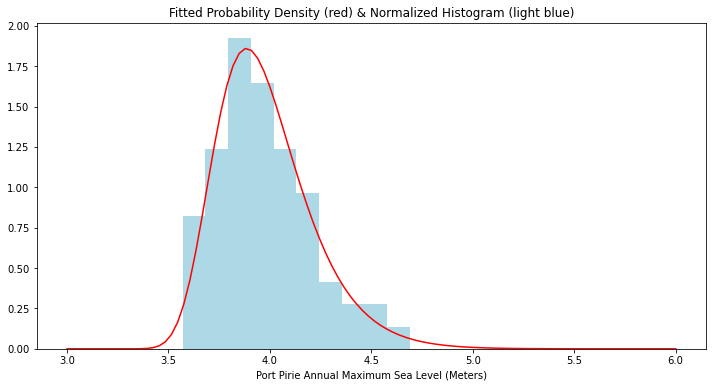

In [17]:
plt.figure(figsize=(12,6))
plt.title("Fitted Probability Density (red) & Normalized Histogram (light blue)")
plt.xlabel("Port Pirie Annual Maximum Sea Level (Meters)")
plt.plot(x,y, color='Red')
plt.hist(max_sea_levels, density=1, color='LightBlue')

### Computing Confidence Regions

A 95% one-sided confidence region can be computed by using the inverse of the cumulative distribution function (CDF) -- called PPF in scipy.stats.  So, from the calculation, below, we can say the there is only a 5% chance that the maximum sea level in given year will be above 4.42 meters, and only a 1% chance it will exceed 4.69 meters.

In [18]:
genextreme.ppf(0.95, xi, loc=mu, scale=sigma)

4.421293904937829

In [19]:
genextreme.ppf(0.99, xi, loc=mu, scale=sigma)

4.688396261965032

In [20]:
print("The maximum recorded sea level is {} meters.".format(max(max_sea_levels)))

The maximum recorded sea level is 4.69 meters.


The probability of seeing a sea level higher than the maximum recorded level is about 1%:

In [21]:
print("{:.4f}%".format(((1 - genextreme.cdf(max(max_sea_levels), xi, loc=mu, scale=sigma)) * 100.0)))

0.9899%
